In [1]:
!pip install kaggle
from google.colab import files

uploaded = files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [2]:
!kaggle datasets download -d lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

 97% 25.0M/25.7M [00:02<00:00, 22.0MB/s]
100% 25.7M/25.7M [00:02<00:00, 12.1MB/s]


In [3]:
import zipfile
with zipfile.ZipFile('/content/imdb-dataset-of-50k-movie-reviews.zip', 'r') as zip_ref:
    zip_ref.extractall('/content')

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import pickle
import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, Add
from tensorflow.keras.layers import add
from tensorflow.keras.utils import plot_model
import nltk
import seaborn as sns

In [290]:
!pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
obj = SentimentIntensityAnalyzer()

In [5]:
df = pd.read_csv('/content/imdb-dataset-of-50k-movie-reviews.zip')
df.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [6]:
df.shape

(50000, 2)

In [7]:
df.isnull().value_counts()

review  sentiment
False   False        50000
dtype: int64

<Axes: xlabel='sentiment', ylabel='count'>

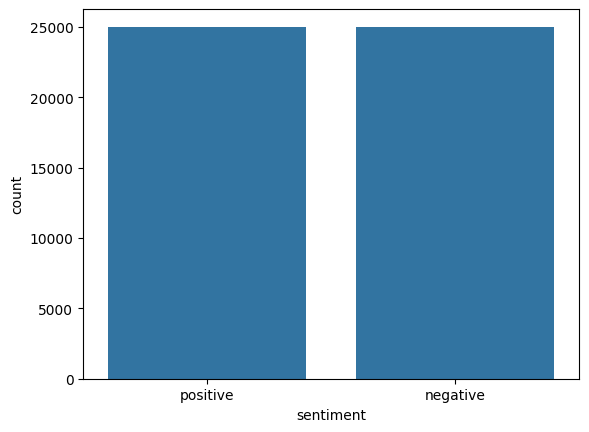

In [8]:
sns.countplot(data=df,x='sentiment')

In [9]:
df['review'][1]

'A wonderful little production. <br /><br />The filming technique is very unassuming- very old-time-BBC fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />The actors are extremely well chosen- Michael Sheen not only "has got all the polari" but he has all the voices down pat too! You can truly see the seamless editing guided by the references to Williams\' diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. A masterful production about one of the great master\'s of comedy and his life. <br /><br />The realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional \'dream\' techniques remains solid then disappears. It plays on our knowledge and our senses, particularly with the scenes concerning Orton and Halliwell and the sets (particularly of their flat with Halliwell\'s murals decorating every surface) are terribly well d

In [10]:
for i, review in enumerate(df['review']):
    df['review'][i] = review.lower()

In [11]:
df

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production. <br /><br />the...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically there's a family where a little boy ...,negative
4,"petter mattei's ""love in the time of money"" is...",positive
...,...,...
49995,i thought this movie did a down right good job...,positive
49996,"bad plot, bad dialogue, bad acting, idiotic di...",negative
49997,i am a catholic taught in parochial elementary...,negative
49998,i'm going to have to disagree with the previou...,negative


In [12]:
import re
def clean_text(text):
    # Remove HTML tags
    text = re.sub('<[^<]+?>', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    return text

df['review'] = df['review'].apply(clean_text)

In [13]:
df.head()

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive


In [14]:
from nltk.corpus import stopwords
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
stopwords_list = stopwords.words('english')

print(stopwords_list)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
stop_words = set(stopwords.words('english'))
def preprocess_text(text):
  text = text.lower()
  text = clean_text(text)
  text = re.sub(r"\s+[a-zA-Z]\s+", ' ',text)
  text = re.sub(r'\s+', ' ',text)
  text = ' '.join([word for word in text.split() if word.lower() not in stop_words])
  text = nltk.word_tokenize(text)
  text = [lemmatizer.lemmatize(word, wordnet.VERB) for word in text]
  text = ' '.join(text)
  return text

In [16]:
text = 'a wonderful little production. <br /><br />the filming technique is very unassuming- very old-time-bbc fashion and gives a comforting, and sometimes discomforting, sense of realism to the entire piece. <br /><br />the actors are extremely well chosen- michael sheen not only "has got all the polari" but he has all the voices down pat too! you can truly see the seamless editing guided by the references to williams diary entries, not only is it well worth the watching but it is a terrificly written and performed piece. a masterful production about one of the great masters of comedy and his life. <br /><br />the realism really comes home with the little things: the fantasy of the guard which, rather than use the traditional dream techniques remains solid then disappears. it plays on our knowledge and our senses, particularly with the scenes concerning orton and halliwell and the sets (particularly of their flat with halliwells murals decorating every surface) are terribly well done.'

In [17]:
preprocess_text(text)

'wonderful little production film technique unassuming oldtimebbc fashion give comfort sometimes discomforting sense realism entire piece actors extremely well choose michael sheen get polari voice pat truly see seamless edit guide reference williams diary entries well worth watch terrificly write perform piece masterful production one great master comedy life realism really come home little things fantasy guard rather use traditional dream techniques remain solid disappear play knowledge sense particularly scenes concern orton halliwell set particularly flat halliwells murals decorate every surface terribly well do'

In [18]:
df['review'] = df['review'].apply(preprocess_text)

In [19]:
df.head()

,review,sentiment
0,one reviewers mention watch 1 oz episode youll...,positive
1,wonderful little production film technique una...,positive
2,think wonderful way spend time hot summer week...,positive
3,basically theres family little boy jake think ...,negative
4,petter matteis love time money visually stun f...,positive


In [216]:
X = df['review']
y = df['sentiment']

In [217]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [220]:
type(X_test)

list

In [218]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [219]:
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [24]:
vocal = tokenizer.word_index

In [25]:
i = 0
for word in vocal:
  i = i + 1

In [26]:
vocal_len = i + 1
vocal_len

179800

In [27]:
len = [len(i) for i in X_train]
max_len = max(len)

(array([1.4939e+04, 1.5069e+04, 5.1610e+03, 2.3980e+03, 1.1400e+03,
        6.4700e+02, 4.0100e+02, 2.0000e+02, 2.7000e+01, 4.0000e+00,
        3.0000e+00, 3.0000e+00, 2.0000e+00, 2.0000e+00, 0.0000e+00,
        2.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 1.0000e+00]),
 array([   4. ,   74.6,  145.2,  215.8,  286.4,  357. ,  427.6,  498.2,
         568.8,  639.4,  710. ,  780.6,  851.2,  921.8,  992.4, 1063. ,
        1133.6, 1204.2, 1274.8, 1345.4, 1416. ]),
 <BarContainer object of 20 artists>)

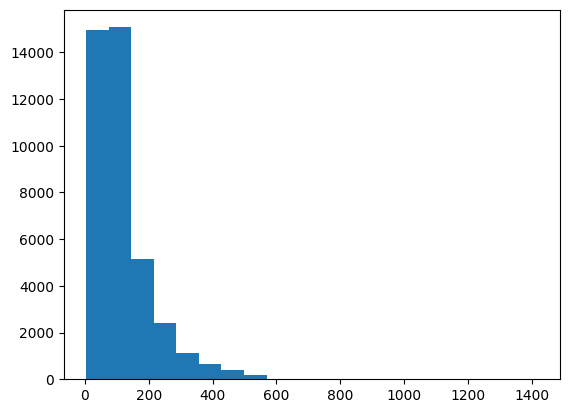

In [28]:
plt.hist(len,bins=20)

In [29]:
max_len = 200
X_train = pad_sequences(X_train,padding='post',maxlen=max_len)
X_test = pad_sequences(X_test,padding='post',maxlen=max_len)

In [30]:
X_train.shape

(40000, 200)

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [32]:
!wget http://nlp.stanford.edu/data/glove.6B.zip


--2024-03-28 07:24:00--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2024-03-28 07:24:01--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2024-03-28 07:24:02--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [33]:
import urllib.request
url = 'http://nlp.stanford.edu/data/glove.6B.zip'
urllib.request.urlretrieve(url, '/content/glove.6B.zip')

('/content/glove.6B.zip', <http.client.HTTPMessage at 0x7d3b592f9990>)

In [34]:
!unzip glove.6B.zip

Archive:  glove.6B.zip
  inflating: glove.6B.50d.txt        
  inflating: glove.6B.100d.txt       
  inflating: glove.6B.200d.txt       
  inflating: glove.6B.300d.txt       


In [35]:
with open("glove.6B.200d.txt", "r", encoding="utf-8") as file:
    embeddings_index = {}
    for line in file:
        values = line.split()
        word = values[0]
        vector = np.array(values[1:], dtype="float32")
        embeddings_index[word] = vector

In [36]:
from numpy import zeros
embedding_matrix = zeros((vocal_len,200))
for word,index in tokenizer.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if embedding_vector is not None:
    embedding_matrix[index] = embedding_vector

In [37]:
embedding_matrix.shape

(179800, 200)

In [38]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.fit_transform(y_test)

### SIMPLE NN

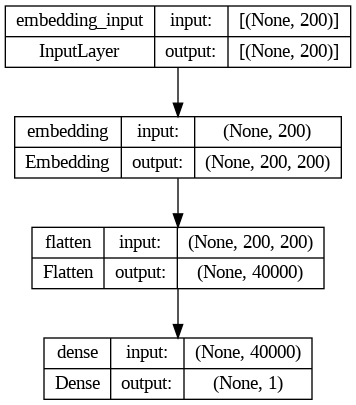

In [39]:
from tensorflow.keras.layers import Flatten

snn_model = Sequential()

el = Embedding(vocal_len,200,weights=[embedding_matrix],input_length=200,trainable = False)

snn_model.add(el)
snn_model.add(Flatten())
snn_model.add(Dense(1,activation='sigmoid'))

plot_model(snn_model, show_shapes=True)

In [40]:
snn_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
print(snn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 200)          35960000  
                                                                 
 flatten (Flatten)           (None, 40000)             0         
                                                                 
 dense (Dense)               (None, 1)                 40001     
                                                                 
Total params: 36000001 (137.33 MB)
Trainable params: 40001 (156.25 KB)
Non-trainable params: 35960000 (137.18 MB)
_________________________________________________________________
None


In [41]:
X_test.shape

(10000, 200)

In [42]:
snn_model.fit(X_train,y_train,batch_size=128,epochs=6,verbose=1,validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 4s 6ms/step - loss: 0.5340 - acc: 0.7396 - val_loss: 0.4876 - val_acc: 0.7749
Epoch 2/6
250/250 [==============================] - 1s 4ms/step - loss: 0.3417 - acc: 0.8560 - val_loss: 0.4999 - val_acc: 0.7765
Epoch 3/6
250/250 [==============================] - 1s 5ms/step - loss: 0.2720 - acc: 0.8949 - val_loss: 0.5256 - val_acc: 0.7730
Epoch 4/6
250/250 [==============================] - 1s 4ms/step - loss: 0.2315 - acc: 0.9156 - val_loss: 0.5525 - val_acc: 0.7750
Epoch 5/6
250/250 [==============================] - 1s 5ms/step - loss: 0.2025 - acc: 0.9290 - val_loss: 0.5856 - val_acc: 0.7675
Epoch 6/6
250/250 [==============================] - 1s 5ms/step - loss: 0.1818 - acc: 0.9412 - val_loss: 0.6089 - val_acc: 0.7688


In [43]:
y_pred = snn_model.predict(X_test)

313/313 [==============================] - 1s 2ms/step


In [44]:
l=[]
for i in y_pred:
  if i<0.5:
    l.append(0)
  else:
    l.append(1)

In [45]:
y_pred1 = np.array(l)
y_pred1

array([0, 1, 0, ..., 0, 0, 0])

In [46]:
y_test

array([1, 1, 0, ..., 1, 0, 1])

In [47]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred1)
print("Accuracy:", accuracy)

Accuracy: 0.7648


In [48]:
import xgboost as xgb
model = xgb.XGBClassifier(n_estimators=1000)
model.fit(X_train, y_train)
y_pred2 = model.predict(X_test)

In [49]:
accuracy = accuracy_score(y_test, y_pred2)
print("Accuracy:", accuracy)

Accuracy: 0.5972


### NOW TRYING WITH CNN MODEL

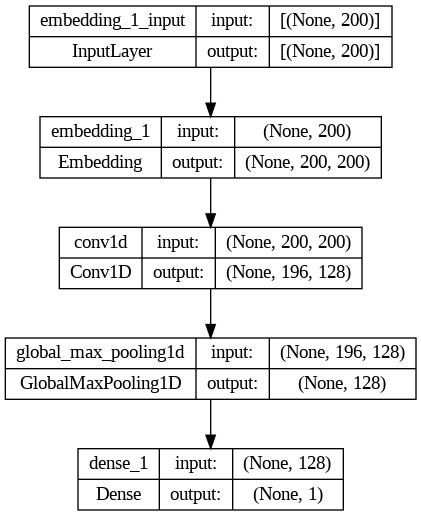

In [50]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense

cnn_model = Sequential()

el = Embedding(vocal_len,200,weights=[embedding_matrix],input_length=200,trainable = False)

cnn_model.add(el)
cnn_model.add(Conv1D(128,5,activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(1,activation='sigmoid'))

plot_model(cnn_model, show_shapes=True)

In [51]:
cnn_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
print(cnn_model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 200)          35960000  
                                                                 
 conv1d (Conv1D)             (None, 196, 128)          128128    
                                                                 
 global_max_pooling1d (Glob  (None, 128)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense_1 (Dense)             (None, 1)                 129       
                                                                 
Total params: 36088257 (137.67 MB)
Trainable params: 128257 (501.00 KB)
Non-trainable params: 35960000 (137.18 MB)
_________________________________________________________________
None


In [52]:
cnn_model.fit(X_train,y_train,batch_size=128,epochs=6,verbose=1,validation_split=0.2)

Epoch 1/6
250/250 [==============================] - 6s 10ms/step - loss: 0.4488 - acc: 0.7880 - val_loss: 0.3550 - val_acc: 0.8493
Epoch 2/6
250/250 [==============================] - 2s 9ms/step - loss: 0.3042 - acc: 0.8743 - val_loss: 0.3466 - val_acc: 0.8499
Epoch 3/6
250/250 [==============================] - 2s 8ms/step - loss: 0.2368 - acc: 0.9108 - val_loss: 0.3228 - val_acc: 0.8639
Epoch 4/6
250/250 [==============================] - 2s 8ms/step - loss: 0.1837 - acc: 0.9385 - val_loss: 0.3182 - val_acc: 0.8649
Epoch 5/6
250/250 [==============================] - 2s 8ms/step - loss: 0.1353 - acc: 0.9628 - val_loss: 0.3462 - val_acc: 0.8569
Epoch 6/6
250/250 [==============================] - 2s 9ms/step - loss: 0.0938 - acc: 0.9834 - val_loss: 0.3312 - val_acc: 0.8696


In [53]:
y_pred = cnn_model.predict(X_test)

313/313 [==============================] - 1s 3ms/step


In [54]:
l1=[]
for i in y_pred:
  if i<0.5:
    l1.append(0)
  else:
    l1.append(1)

In [55]:
y_pred1 = np.array(l1)
y_pred1

array([0, 1, 0, ..., 0, 0, 1])

In [56]:
y_test

array([1, 1, 0, ..., 1, 0, 1])

In [57]:
accuracy = accuracy_score(y_test, y_pred1)
print("Accuracy:", accuracy)

Accuracy: 0.8666


### NOW USING RNN WITH LSTM


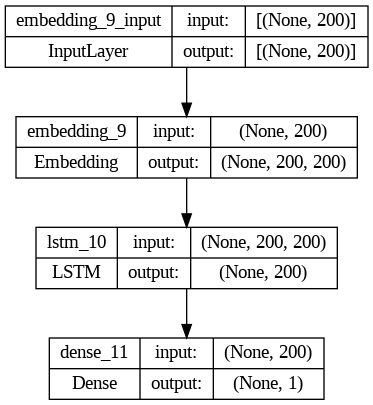

In [87]:
from keras.layers import LSTM, Dropout

lstm_model = Sequential()
el = Embedding(vocal_len, 200, weights=[embedding_matrix], input_length=200, trainable=False)
lstm_model.add(el)
lstm_model.add(LSTM(200))
lstm_model.add(Dense(1, activation='sigmoid'))
plot_model(lstm_model, show_shapes=True)

In [88]:
lstm_model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['acc'])
print(lstm_model.summary())

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 200, 200)          35960000  
                                                                 
 lstm_10 (LSTM)              (None, 200)               320800    
                                                                 
 dense_11 (Dense)            (None, 1)                 201       
                                                                 
Total params: 36281001 (138.40 MB)
Trainable params: 321001 (1.22 MB)
Non-trainable params: 35960000 (137.18 MB)
_________________________________________________________________
None


In [90]:
lstm_model.fit(X_train,y_train,batch_size=128,epochs=2,verbose=1,validation_split=0.2)

Epoch 1/2
250/250 [==============================] - 8s 32ms/step - loss: 0.3378 - acc: 0.8550 - val_loss: 0.3259 - val_acc: 0.8602
Epoch 2/2
250/250 [==============================] - 8s 32ms/step - loss: 0.3199 - acc: 0.8627 - val_loss: 0.3138 - val_acc: 0.8673


In [91]:
y_pred = lstm_model.predict(X_test)

313/313 [==============================] - 4s 10ms/step


In [92]:
y_pred.shape

(10000, 1)

In [93]:
l2 = []
for i in y_pred:
    if i < 0.5:
        l2.append(0)
    else:
        l2.append(1)


In [94]:
y_pred1 = np.array(l2)
y_pred1

array([1, 1, 0, ..., 1, 0, 1])

In [95]:
y_test

array([1, 1, 0, ..., 1, 0, 1])

In [96]:
accuracy = accuracy_score(y_test, y_pred1)
print("Accuracy:", accuracy)

Accuracy: 0.8615


In [310]:
Sentence = "I never knew I could feel so much, yet be so numb."

In [311]:
sentence = preprocess_text(Sentence)
text = []
text.append(sentence)
text = tokenizer.texts_to_sequences(text)
text = pad_sequences(text,padding='post',maxlen=max_len)
pred = lstm_model.predict(text)
l3 = []
for i in pred:
    if i < 0.5:
        l3.append(0)
    else:
        l3.append(1)

print("-" * 30)

pred = np.array(l3)
if pred == 1:
  print('Positive Sentiment by LSTM MODEL')
else:
  print('Negative Sentiment by LSTM MODEL')

print("-" * 30)

dict = obj.polarity_scores(sentence)
if dict['compound'] < 0:
  print('Negative Sentiment by Vader Sentiment Analyzer')
else:
  print('Positive Sentiment by Vader Sentiment Analyzer')

print("-" * 30)

1/1 [==============================] - 0s 78ms/step
------------------------------
Negative Sentiment by LSTM MODEL
------------------------------
Negative Sentiment by Vader Sentiment Analyzer
------------------------------
